# ml lab2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1.1 read lab1 data

In [2]:
import os

DATA_PATH = '../lab1/data/notMNIST_small'

letters = sorted(os.listdir(DATA_PATH))

image_width = 28

X = []
y = []

for l_id, letter in enumerate(letters):
    l_dir = f'{DATA_PATH}/{letter}'
    for image in os.listdir(l_dir):
        try:
            img = plt.imread(f'{l_dir}/{image}')
            X.append(img.reshape(-1, image_width * image_width)[0])
            y.append(l_id)
        except:
            continue

In [3]:
len(X), len(y)

(18724, 18724)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(X_test)

(14979, 3745)

### 1.2 build network

In [5]:
import torch
import torch.nn as nn

In [6]:
epochs = 100
batch_size = 512
learning_rate = 1e-3

mu = np.mean(X)
std = np.std(X)

In [52]:
network = nn.Sequential(
    nn.Linear(784, 900),
    nn.LeakyReLU(),
    nn.Linear(900, 900),
    nn.LeakyReLU(),
    nn.Linear(900, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 10),
)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [53]:
network.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=900, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=900, out_features=900, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=900, out_features=500, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=500, out_features=10, bias=True)
)

In [54]:
import torch.optim as optim

optimizer = optim.Adagrad(network.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

x_tensor = torch.FloatTensor(X_train)
y_tensor = torch.LongTensor(y_train)

x_test_ten = torch.FloatTensor(X_test).to(device)
y_test_ten = torch.LongTensor(y_test).to(device)

n = len(X_train)
n

14979

In [105]:
from tqdm import tqdm

def train(_net, _opt, _x, _y, epochs):
    loss_data = []

    pbar = tqdm(range(epochs))
    for e in pbar:
        e_loss = None
        for i in range(0, n - batch_size, batch_size):
            x_i = _x[i:i + batch_size].to(device)
            y_i = _y[i:i + batch_size].to(device)

            _opt.zero_grad()
            predict = _net(x_i)

            loss = loss_func(predict, y_i)
            loss.backward()
            _opt.step()
            
            e_loss = loss.data
        loss_data.append(e_loss)
        pbar.set_description(f'[e#{e} loss: {e_loss:.3f}]')
    return loss_data

In [56]:
loss_history = train(network, optimizer, x_tensor, y_tensor)

[e#99 loss: 0.087]: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


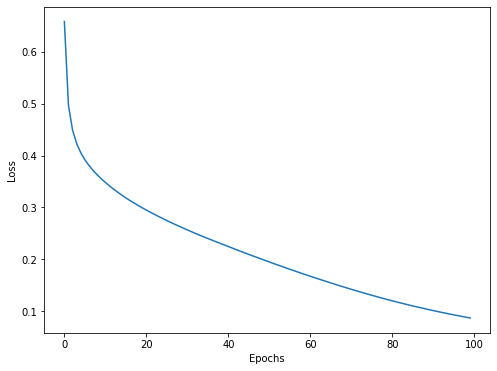

In [58]:
def draw(data):
    plt.figure(figsize=(8, 6))
    plt.plot(data)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

network.eval();
draw(loss_history)

### 2. accuracy

In [69]:
from sklearn.metrics import accuracy_score

def get_accuracy(net, normilize=False):
    test_tensor = torch.FloatTensor(X_test).to(device)
    if normilize:
        test_tensor = (test_tensor - mu) / std
    test_predict = net(test_tensor)

    _, max_index = torch.max(test_predict, 1)
    y_predict = max_index.tolist()

    return accuracy_score(y_predict, y_test)

test_score = get_accuracy(network)
print(f'Accuracy:\t{test_score:.2%}')

Accuracy:	92.04%


> `92%` vs `86.7%` with logistic regression

### 3. regularization & dropout vs overfitting

In [147]:
d_network = nn.Sequential(
    nn.Linear(784, 900),
    nn.BatchNorm1d(num_features=900),
    nn.LeakyReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(900, 900),
    nn.LeakyReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(900, 500),
    nn.LeakyReLU(),
    nn.Dropout(0.25),
    
    nn.Linear(500, 10),
    nn.LogSoftmax(dim=1)
)

d_network.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=900, bias=True)
  (1): BatchNorm1d(900, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=900, out_features=900, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Dropout(p=0.25, inplace=False)
  (7): Linear(in_features=900, out_features=500, bias=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Dropout(p=0.25, inplace=False)
  (10): Linear(in_features=500, out_features=10, bias=True)
  (11): LogSoftmax()
)

In [141]:
x_norm_tensor = torch.FloatTensor((X_train - mu) / std)
y_norm_tensor = torch.LongTensor(y_train)

optimizer2 = optim.Adagrad(d_network.parameters(), lr=learning_rate)

In [142]:
norm_loss_history = train(d_network, optimizer2, x_tensor, y_tensor, 200)

[e#199 loss: 0.090]: 100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


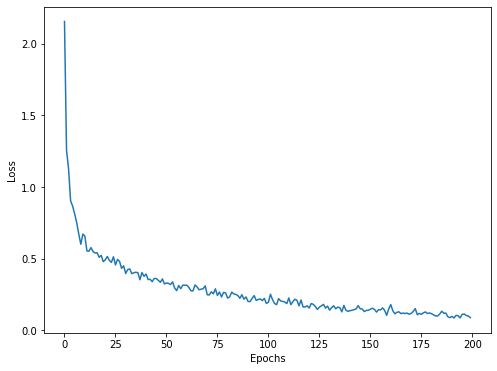

In [143]:
d_network.eval();
draw(norm_loss_history)

In [144]:
print(f'Accuracy:\t{get_accuracy(d_network):.2%}')

Accuracy:	92.20%


### 4. dynamic learning rate

In [148]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

epochs = 100
learning_rate = 0.1
optimizer3 = torch.optim.SGD(d_network.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer3, mode='max', factor=0.1, patience=0, verbose=True)

In [149]:
loss_data = []

for e in range(epochs):
    for i in range(0, n - batch_size, batch_size):
        x_i = x_norm_tensor[i:i + batch_size].to(device)
        y_i = y_norm_tensor[i:i + batch_size].to(device)
        
        optimizer3.zero_grad()
        predict = d_network(x_i)
        
        loss = loss_func(predict, y_i)
        loss.backward()
        optimizer3.step()
        
        if i % 1000 == 0:
            loss_data.append(loss.data)
    accuracy = get_accuracy(d_network, True)
    if e % 10 == 0:
        print(f'Epoch\t{e}:\tloss: {loss.data:.3f}\taccuracy: {accuracy:.3f}')
    scheduler.step(accuracy)

Epoch	0:	loss: 0.433	accuracy: 0.883
Epoch     7: reducing learning rate of group 0 to 1.0000e-02.
Epoch    10: reducing learning rate of group 0 to 1.0000e-03.
Epoch	10:	loss: 0.078	accuracy: 0.920
Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch    13: reducing learning rate of group 0 to 1.0000e-05.
Epoch    14: reducing learning rate of group 0 to 1.0000e-06.
Epoch    15: reducing learning rate of group 0 to 1.0000e-07.
Epoch    16: reducing learning rate of group 0 to 1.0000e-08.
Epoch	20:	loss: 0.065	accuracy: 0.917
Epoch	30:	loss: 0.072	accuracy: 0.916
Epoch	40:	loss: 0.075	accuracy: 0.918
Epoch	50:	loss: 0.070	accuracy: 0.917
Epoch	60:	loss: 0.069	accuracy: 0.916
Epoch	70:	loss: 0.075	accuracy: 0.916
Epoch	80:	loss: 0.078	accuracy: 0.919
Epoch	90:	loss: 0.068	accuracy: 0.919


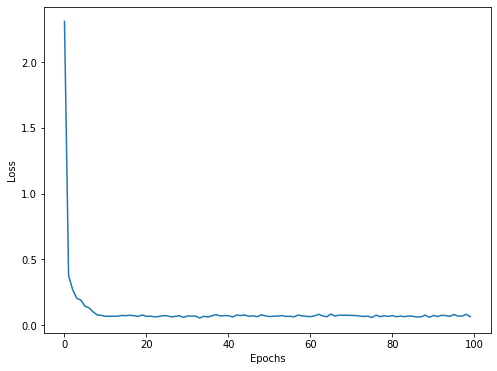

In [150]:
draw(loss_data)
d_network.eval();

In [151]:
print(f'Accuracy:\t{get_accuracy(d_network, True):.2%}')

Accuracy:	92.47%
